In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

## Importing the data

In [2]:
df = pd.read_csv('data.csv', encoding = 'unicode_escape')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,549222,16008,SMALL FOLDING SCISSOR(POINTED EDGE),24,4/7/2011,0.25,12347
1,556201,17021,NAMASTE SWAGAT INCENSE,36,6/9/2011,0.30,12347
2,542237,22134,MINI LADLE LOVE HEART RED,12,1/26/2011,0.42,12347
3,573511,23508,MINI PLAYING CARDS DOLLY GIRL,20,10/31/2011,0.42,12347
4,573511,23506,MINI PLAYING CARDS SPACEBOY,20,10/31/2011,0.42,12347


## Data Preprocessing

In [4]:
df['Spend'] = df['UnitPrice']*df['Quantity']
df = df[['CustomerID','InvoiceDate', 'InvoiceNo', 'Spend']]
df.head()

,CustomerID,InvoiceDate,InvoiceNo,Spend
0,12347,4/7/2011,549222,6.00
1,12347,6/9/2011,556201,10.80
2,12347,1/26/2011,542237,5.04
3,12347,10/31/2011,573511,8.40
4,12347,10/31/2011,573511,8.40


In [5]:
# Check for Null Values
df.isnull().any()

CustomerID     False
InvoiceDate    False
InvoiceNo      False
Spend          False
dtype: bool

In [6]:
# Check the types for each column
df.dtypes

CustomerID       int64
InvoiceDate     object
InvoiceNo        int64
Spend          float64
dtype: object

In [7]:
# Convert InvoiceDate into date format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate'] = [x.date() for x in df['InvoiceDate']]

### Calculate Recency, Frequency and MonetaryValue

- **Recency**: Days between the snapshot date (last order date from the data set + 1) and the customer's most recent order date
- **Frequency**: Number of purchases made by the customer
- **MonetaryValue**: Total spend by the customer

In [8]:
# Create snapshot_date
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

In [9]:
# Calculate Recency, Frequency and Moneytary value for each customer

dfc = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'Spend': 'sum'
})

# Rename columns for easier interpretation
dfc.rename(columns = 
           {'InvoiceDate': 'Recency',
            'InvoiceNo': 'Frequency',
            'Spend': 'MonetaryValue'}, inplace=True)

dfc.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347,3,182,4310.00
12348,76,31,1797.24
12349,19,73,1757.55
12350,311,17,334.40
12352,37,85,2506.04


### Preparing Data for K-means Clusterings

Before we apply K-means clusterings, there are several key assumtions we have to consider:
- **Symmetric distribution** of variables (not skewed)
- All variables have the **same mean**
- All variables have the **same variance**

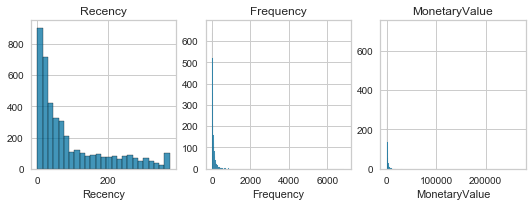

In [10]:
#Plot each variables and check if the distribution is skewed.
plt.figure(figsize=(12,6))

plt.subplot(2,4,1)
sns.histplot(dfc['Recency'])
plt.title('Recency')
plt.ylabel('')

plt.subplot(2,4,2)
sns.histplot(dfc['Frequency'])
plt.title('Frequency')
plt.ylabel('')

plt.subplot(2,4,3)
sns.histplot(dfc['MonetaryValue'])
plt.title('MonetaryValue')
plt.ylabel('')

plt.show()

Notice that all three variables are right skewed and so I applied log transformation to manage the skewness.

In [11]:
dfc['Recency'] = np.log(dfc['Recency'])
dfc['Frequency'] = np.log(dfc['Frequency'])
dfc['MonetaryValue'] = np.log(dfc['MonetaryValue'])

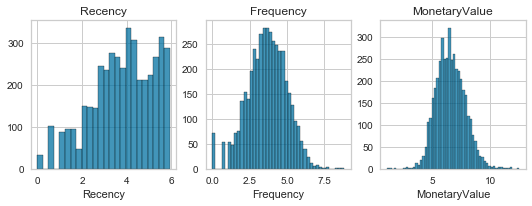

In [12]:
plt.figure(figsize=(12,6))

plt.subplot(2,4,1)
sns.histplot(dfc['Recency'])
plt.title('Recency')
plt.ylabel('')

plt.subplot(2,4,2)
sns.histplot(dfc['Frequency'])
plt.title('Frequency')
plt.ylabel('')

plt.subplot(2,4,3)
sns.histplot(dfc['MonetaryValue'])
plt.title('MonetaryValue')
plt.ylabel('')

plt.show()

In [13]:
dfc.describe()

,Recency,Frequency,MonetaryValue
count,4333.000000,4333.000000,4333.000000
mean,3.803294,3.659633,6.572789
std,1.381691,1.315309,1.248713
min,0.000000,0.000000,1.064711
25%,2.890372,2.833213,5.725087
50%,3.931826,3.688879,6.502940
75%,4.962845,4.574711,7.399802
max,5.924256,8.838407,12.498230


The variables have different means and standard deviations, so I used the StandardScaler to normalize the data for Kmeans to work best.

In [14]:
#Center and scale with StandardScaler()
scaler = StandardScaler()
scaler.fit(dfc)
dfc_normalized = scaler.transform(dfc)
dfc_normalized = pd.DataFrame(dfc_normalized, index=dfc.index, columns=dfc.columns)
dfc_normalized.describe().round(2)

,Recency,Frequency,MonetaryValue
count,4333.00,4333.00,4333.00
mean,-0.00,-0.00,0.00
std,1.00,1.00,1.00
min,-2.75,-2.78,-4.41
25%,-0.66,-0.63,-0.68
50%,0.09,0.02,-0.06
75%,0.84,0.70,0.66
max,1.54,3.94,4.75


StandardScaler() standardizes the data by removing the mean and scaling to unit varaince.

### Choosing the number of clusters

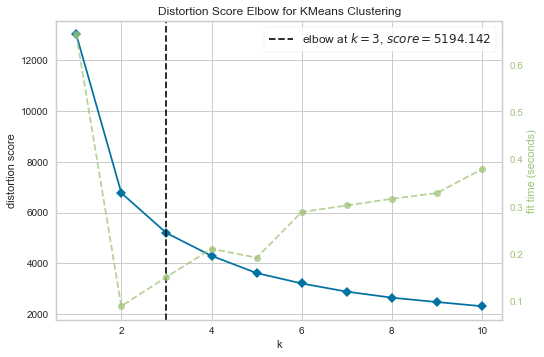

In [15]:
# Elbow method / SSE Plot

km = KMeans(random_state=1)
visualizer = KElbowVisualizer(km, k=(1,11))
 
visualizer.fit(dfc_normalized)        # Fit the data to the visualizer
visualizer.show() 

As per the plot, n_clusters = 3 represents the elbow you start seeing that the line starts looking linear.

### Run KMeans with 3 clusters

In [16]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(dfc_normalized)
labels = kmeans.fit_predict(dfc_normalized)

# Create a pandas DataFrame by adding a cluster label column
dfc_cluster = dfc.assign(Cluster=labels)
dfc_cluster.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347,1.098612,5.204007,8.368693,2
12348,4.330733,3.433987,7.494007,1
12349,2.944439,4.290459,7.471676,1
12350,5.739793,2.833213,5.812338,0
12352,3.610918,4.442651,7.826459,1


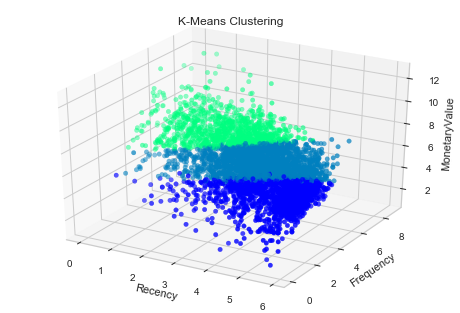

In [17]:
#Plot the clusters obtained using k means
centers = kmeans.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(dfc_cluster['Recency'],dfc_cluster['Frequency'], dfc_cluster['MonetaryValue'],
                     c=labels,s=20, cmap='winter')

ax.set_title('K-Means Clustering')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('MonetaryValue')
plt.show()

In [18]:
dfc_cluster.groupby('Cluster').agg({
    'Recency':['mean','min', 'max'],
    'Frequency':['mean','min', 'max'],
    'MonetaryValue':['mean','min', 'max', 'count']
}).round(2)

Recency             Frequency             MonetaryValue              \
           mean   min   max      mean   min   max          mean   min   max   
Cluster                                                                       
0          4.88  0.69  5.92      2.34  0.00  4.33          5.39  1.06   7.6   
1          3.81  0.69  5.92      3.89  1.10  6.13          6.68  4.74   9.2   
2          2.23  0.00  4.82      5.16  2.71  8.84          8.09  6.14  12.5   

               
        count  
Cluster        
0        1459  
1        1870  
2        1004

From the statistics summary:<br>
Cluster 2 is the most valuable group of customers with highest mean Frequency (purchase most often) and mean MonetaryValue, lowest mean Recency (has recently purchase from the company). <br>
Cluster 0 is the worst group with lowest Frequency and MonetaryValue and highest Recency.